<a href="https://colab.research.google.com/github/guoguolee88/Histopathologic-Cancer_Detection/blob/master/KAGGLE_CANCER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histopathologic Cancer Detection

##Purpose of the Analysis
To study an algorithm to identify metastatic cancer (the development of secondary malignant growths at a distance from a primary site of cancer) in small image patches taken from larger digital pathology scans. 


###PCam Data on Kaggle
The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates)



### Histopathological images
The histopathological images are glass slide microscope images of lymph nodes that are stained with hematoxylin and eosin (H&E). This staining method is one of the most widely used in medical diagnosis and it produces blue, violet and red colors. **Dark blue** hematoxylin binds to negatively charged substances such as nucleic acids and **pink eosin** to positively charged substances like amino-acid side chains (most proteins). Typically nuclei are stained blue, whereas cytoplasm and extracellular parts in various shades of pink.

Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread. Histological assessment of lymph node metastases is part of determining the stage of breast cancer in TNM classification which is a globally recognized standard for classifying the extent of spread of cancer. The diagnostic procedure for pathologists is tedious and time-consuming as a large area of tissue has to be examined and small metastases can be easily missed.

### Dataset

According to the data description, there is a 50/50 balance between positive and negative examples in the training and test splits. However, the training distribution seems to be 60/40 (negatives/positives). A positive label means that there is at least one pixel of tumor tissue in the center region (32 x 32px) of the image. Tumor tissue in the outer region of the patch does not influence the label. This means that a negatively labeled image could contain metastases in the outer region. Thus, it would be a good idea to crop the images to the center region.

According to the data description, the dataset has been stripped of duplicates. However, this has not been confirmed by testing.

For the entire dataset, when the slide-level label was unclear during the inspection of the H&E-stained slide, an additional WSI with a consecutive tissue section, immunohistochemically stained for cytokeratin, was used to confirm the classification.

In this dataset, a large number of small pathology images were provided to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. A positive label indicates that the center 96 x 96px region of a patch contains at least one pixel of tumor tissue. One key challenge is that the metastases can be as small as single cells in a large area of tissue. 

*Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image, which we will demonstrate in the prediction phase.*



### Model

Classifying metastases is probably not an easy task for a trained pathologist and extremely difficult for an untrained eye. The irregular nuclear shapes, sizes or staining shades can indicate metastases.

#### Modeling
The label of the image is influenced only by the center region (32 x 32px) so it would make sense to crop our data to that region only. However, some useful information about the surroundings could be lost if we crop too close. This hypothesis could be confirmed by training models with varying crop sizes. (The results with 32 x 32px size showed worse performance than with 48 x 48px.)To remove  bad data, too unfocused or corrupted to increase the overall quality.

#### Preprocessing and augmentation
There are couple of ways we can use to avoid overfitting; more data, augmentation, regularization and less complex model architectures. Here we will define what image augmentations to use and add them directly to our image loader function. Note that if we apply augmentation here, augmentations will also be applied when we are predicting (inference). This is called test time augmentation (TTA) and it can improve our results if we run inference multiple times for each image and average out the predictions.

#### Evaluation
The valuation metric is [area under the ROC curve](http://en.wikipedia.org/wiki/Receiver_operating_characteristic).The ROC curve is a plot of *True positive rate* against *False positive rate* at various thresholds and the area under the curve (AUC) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. The best possible solution would yield an AUC of 1 which means we would classify all positive samples correctly without getting any false positives. 

![ROC curve example](https://i.ibb.co/mBKh6ZB/roc.png)
<p style="text-align: center;"> ROC curve from a previous run of this kernel </p>
*For the model, we have fine-tuned a NASNet network to fit this particular task, which we will train in order to get a good accuracy on the validation set. Actually, This model has enabled us to obtain an AUC-ROC score of 0.9526 which is good enough to point out with a good accuracy the regions where the cancer probably is present, thus greatly contributing to a doctor's diagnosis.*

## Downloading the data


In [1]:
from tensorflow import keras
from tensorflow.keras import layers

Navigate to the Kaggle website (https://www.kaggle.com/) in a web browser, log in, and go to the My Account page. In your account settings, you’ll find an API section. Clicking the Create New API Token button will generate a kaggle.json key file and will download it to your machine. Then go to your Colab notebook, and upload the API’s key JSON file to your Colab session by running the following code in a notebook cell:

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"guoguolee88","key":"c931391f8c40cda4b7597999022f29e2"}'}

you will see a Choose Files button appear. Click it and select the **kaggle.json** file you just downloaded. This uploads the file to the local Colab runtime.

In [3]:
!pip install -U -q kaggle
!mkdir ~/.kaggle # make directory 
!cp kaggle.json ~/.kaggle/ # copy the file
!chmod 600 ~/.kaggle/kaggle.json # change permissions on API key file make it only readable to yourself 

In [4]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [01:25<00:00, 109MB/s]
100% 6.31G/6.31G [01:26<00:00, 78.8MB/s]


In [5]:
!unzip -qq histopathologic-cancer-detection.zip


## Downloading necessary libraries

In [36]:
import numpy as np
import pandas as pd
from glob import glob
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
#from keras.layers.pooling import _GlobalPooling1D
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy
from keras.models import Model
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from imgaug import augmenters as iaa
import imgaug as ia
#!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Data visualization

###High level data stats

In [7]:
data = pd.read_csv('/content/train_labels.csv')
train_path = '/content/train/'
test_path = '/content/test/'

In [8]:
data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [9]:
data.shape

(220025, 2)

In [10]:
count = data['label'].value_counts()
freq = data['label'].value_counts(normalize = True)
# freq = count/len(data)

y_freq = pd.DataFrame({'label': list(map(str, count.index)),
                       'count': count,
                       'freq': freq})

y_freq

,label,count,freq
0,0,130908,0.594969
1,1,89117,0.405031


The negative/positive ratio is not entirely 50/50 as there are 130k negatives and 90k negatives. The ratio is closer to 60/40 meaning that there are 1.5 times more negative images than positives.

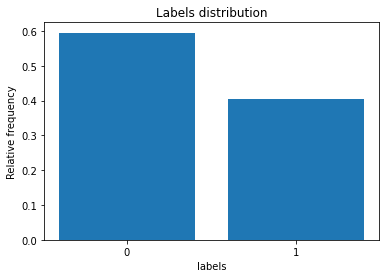

In [11]:
plt.subplot()
plt.bar(y_freq.loc[:, 'label'],
        y_freq.loc[:, 'freq'])
plt.xlabel('labels')
plt.ylabel('Relative frequency')
plt.title('Labels distribution')
plt.show()

###Plot some images with and without cancer tissue for comparison

In [12]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img / 255

In [13]:
# random sampling
shuffled_data = shuffle(data)


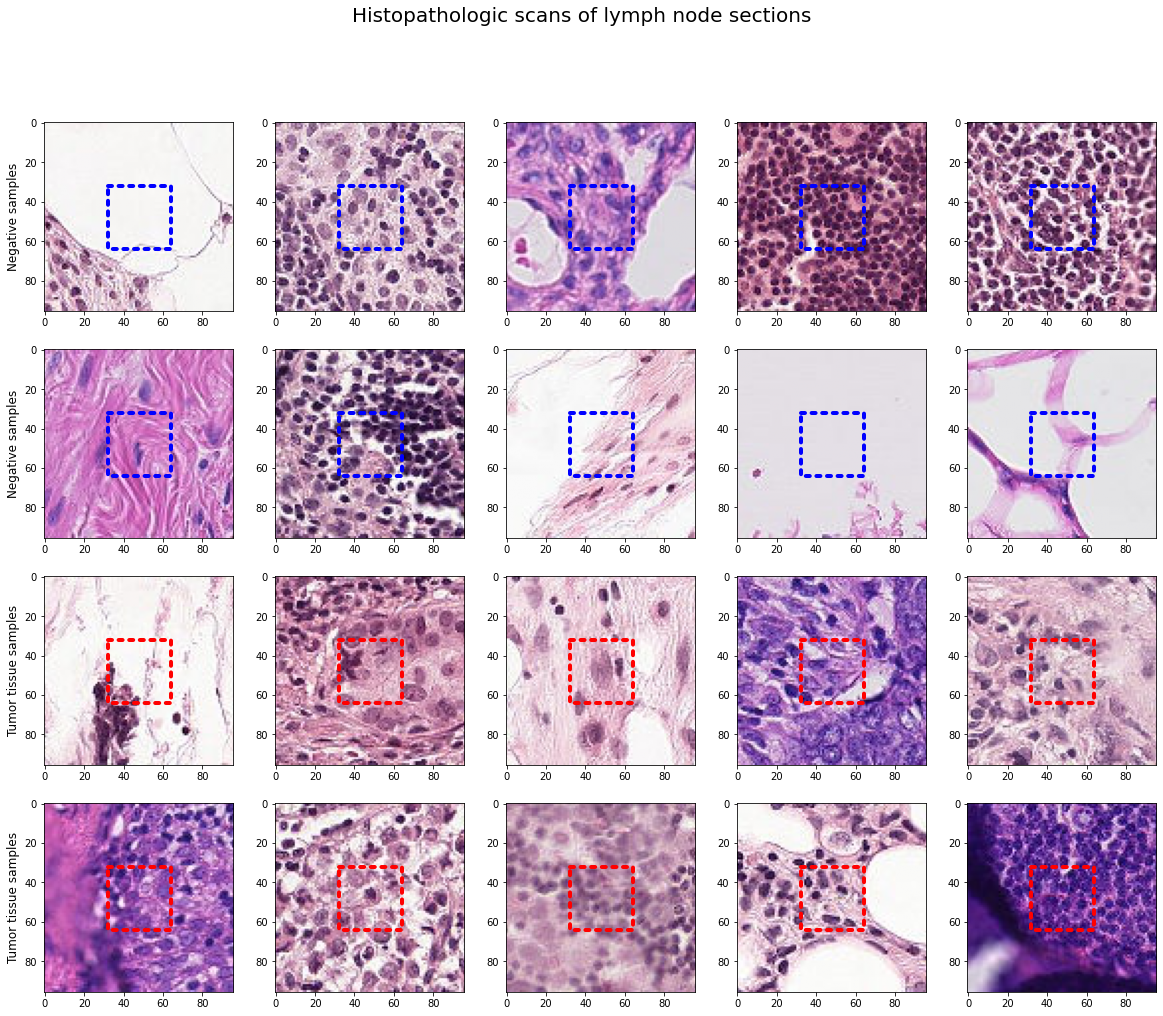

In [14]:
#fig, ax = plt.subplots(2,5, figsize=(20,8))
fig, ax = plt.subplots(4,5, figsize=(20,16))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives

for j in [0,1]:
    for i, idx in enumerate(data[data['label'] == 0]['id'][(j*5):((j+1)*5)]):
        path = os.path.join(train_path, idx)
        ax[j,i].imshow(readImage(path + '.tif'))
        # Create a Rectangle patch
        # box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='g',
        #                    facecolor='none', linestyle=':', capstyle='round')
        box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',
                            facecolor='none', linestyle=':', capstyle='round')
        ax[j,i].add_patch(box)
    ax[j,0].set_ylabel('Negative samples', size='large')

for j in [0,1]:
    # Positives
    for i, idx in enumerate(data[data['label'] == 1]['id'][(j*5):((j+1)*5)]):
        path = os.path.join(train_path, idx)
        ax[(j+2),i].imshow(readImage(path + '.tif'))
        # Create a Rectangle patch
        box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',
                            facecolor='none', linestyle=':', capstyle='round')
        ax[(j+2),i].add_patch(box)
    ax[(j+2),0].set_ylabel('Tumor tissue samples', size='large')

### Preprocessing and augmentation


There are couple of ways we can use to avoid overfitting; more data, augmentation, regularization and less complex model architectures. Here we will define what image augmentations to use and add them directly to our image loader function. Note that if we apply augmentation here, augmentations will also be applied when we are predicting (inference). This is called test time augmentation (TTA) and it can improve our results if we run inference multiple times for each image and average out the predictions. The augmentations we can use for this type of data:

1.   random rotation
2.   random crop
3.   random flip (horizontal and vertical both)
4.   random lighting
5.   random zoom  (not implemented here)
6.   Gaussian blur (not implemented here)

We will use OpenCV with image operations because OpenCV is a lot faster than PIL or scikit-image.

https://colab.research.google.com/github/guoguolee88/https-github.com-gsarti-cancer-detection/blob/master/densenet/densenet_kaggle.ipynb#scrollTo=699ptY7LsSez

#### Random rotation, crop, flip

In [15]:
import random
ORIGINAL_SIZE = 96      # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 90          # final size after crop
# CROP_SIZE = 80
# CROP_SIZE = 66        # Ha senso mettere crop = 66, così non ci sono pixel neri dopo la rotazione
# CROP_SIZE = 60
# CROP_SIZE = 48
RANDOM_ROTATION = 3     # range (0-180), 180 allows all rotation variations, 0=no change
# RANDOM_ROTATION = 30
# RANDOM_ROTATION = 45
RANDOM_SHIFT = 2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
# RANDOM_SHIFT = 8
RANDOM_BRIGHTNESS = 7   # range (0-100), 0=no change
RANDOM_CONTRAST = 5     # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right

In [16]:
def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # random rotation
    # Clockwise rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT) # Horizontal shift to the right
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT) # Vertical shift to the bottom
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    # rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    rgb_img = rgb_img[(start_crop - y):(end_crop - y), (start_crop - x):(end_crop - x)] / 255
    
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img

In [17]:
def readCroppedImage2(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255, 0, 0, 0
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
    
    # random rotation
    # Clockwise rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT) # Horizontal shift to the right 
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT) # Vertical shift to the bottom
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop - y):(end_crop - y), (start_crop - x):(end_crop - x)] / 255
       
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img, rotation, x, y

/content/train/f38a6374c348f90b587e046aac6079959adf3835


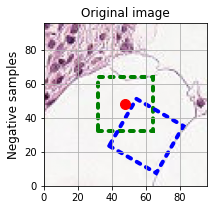

In [18]:
# Prove matplotlib

# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import matplotlib as mpl

# fig = plt.figure()
# ax = fig.add_subplot(111)

fig, ax = plt.subplots(1,1,figsize=(3,3))
fig.subplots_adjust(hspace=0,wspace=0)

ts = ax.transData
coords = [48, 48]
tr = mpl.transforms.Affine2D().rotate_deg_around(x=coords[0], y=coords[1], degrees=-30)
tt = mpl.transforms.Affine2D().translate(20, -10)
# tr = mpl.transforms.Affine2D().rotate_deg(degrees=-30)
t = tt + tr + ts

box_1 = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='g',
                          facecolor='none', linestyle=':', capstyle='round')

ax.add_patch(box_1)

box_2 = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',
                          facecolor='none', linestyle=':', capstyle='round',
                          transform=t)

ax.add_patch(box_2)

plt.plot(coords[0], coords[1], marker='o', markersize=10, color="r")

plt.grid(True)

ax.set_xlim(0,96)
ax.set_ylim(0,96)

plt.title('Original image')

plt.ylabel('Negative samples', size='large')

path = os.path.join(train_path, data[data['label'] == 0].loc[0,'id'])
print(path)

plt.imshow(readImage(path + '.tif'))


plt.show()

/content/train/f38a6374c348f90b587e046aac6079959adf3835.tif


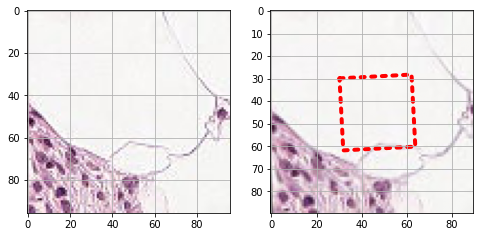

In [19]:
# Read manually the image
path = os.path.join(train_path, data[data['label'] == 0].loc[0,'id']) + '.tif'
print(path)

# OpenCV reads the image in bgr format by default
bgr_img = cv2.imread(path)

# We flip it to rgb for visualization purposes
b,g,r = cv2.split(bgr_img)
rgb_img = cv2.merge([r,g,b])

fig, ax = plt.subplots(1,2, figsize=(8,16))
ax[0].imshow(rgb_img)
ax[0].grid(True)

## Random flip
#flip_hor = bool(random.getrandbits(1))
#flip_ver = bool(random.getrandbits(1))
#if(flip_hor):
#    rgb_img = rgb_img[:, ::-1]
#if(flip_ver):
#    rgb_img = rgb_img[::-1, :]
    
# random rotation
# rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
# if(RANDOM_90_DEG_TURN == 1):
#    rotation += random.randint(-1,1) * 90

# Clockwise rotation
# rotation = 135
rotation = RANDOM_ROTATION

M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
rgb_img = cv2.warpAffine(rgb_img,M,(96,96))

#random x,y-shift
# x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
# y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
# x = 8  # Horizontal shift to the right
x = RANDOM_SHIFT  # Horizontal shift to the right
y = 0             # Vertical shift to the bottom
# RANDOM_SHIFT must be between 0 and (ORIGINAL_SIZE - CROP_SIZE) // 2

# crop to center and normalize to 0-1 range
start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
end_crop = start_crop + CROP_SIZE
rgb_img = rgb_img[(start_crop - y):(end_crop - y), (start_crop - x):(end_crop - x)] / 255
   
## Random brightness
#br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
#rgb_img = rgb_img + br

## Random contrast
#cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
#rgb_img = rgb_img * cr

## clip values to 0-1 range
#rgb_img = np.clip(rgb_img, 0, 1.0)

ax[1].imshow(rgb_img)

ts = ax[1].transData
tr = mpl.transforms.Affine2D().rotate_deg_around(x = CROP_SIZE/2, y = CROP_SIZE/2, degrees = -rotation)
tt = mpl.transforms.Affine2D().translate(x, y)
t = tr + tt + ts

box = patches.Rectangle((32-(ORIGINAL_SIZE - CROP_SIZE)/2,32-(ORIGINAL_SIZE - CROP_SIZE)/2),
                         32,32,linewidth=4,edgecolor='r',
                         facecolor='none', linestyle=':', capstyle='round',
                         transform = t)
ax[1].add_patch(box)
ax[1].grid(True)

Text(0, 0.5, 'Tumor tissue samples')

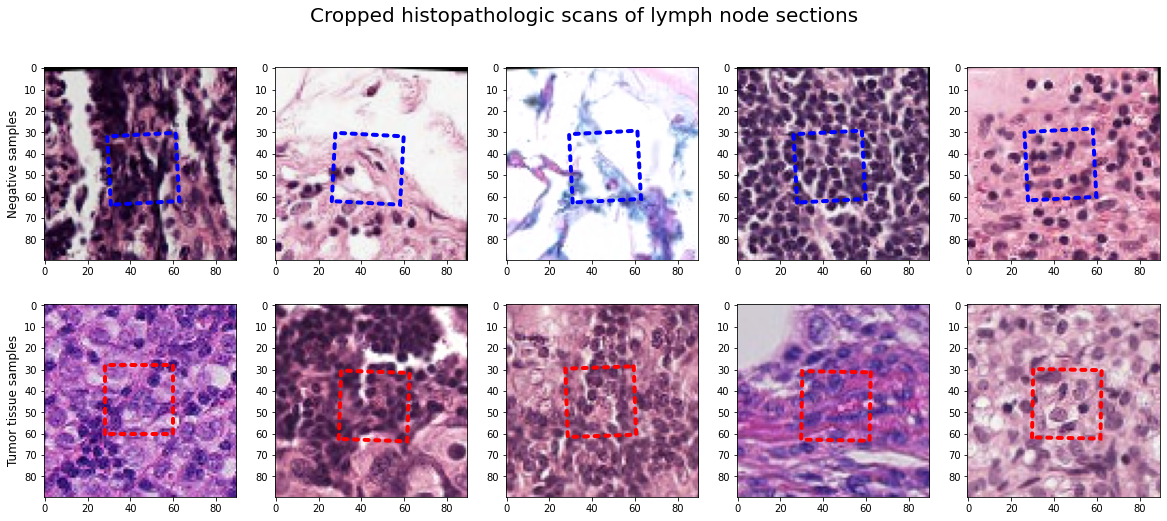

In [20]:
# Nota: ci sono degli errori nelle traslazioni
# non capisco come risolverli

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    img, rotation, x_shift, y_shift = readCroppedImage2(path + '.tif')
    ax[0,i].imshow(img)
       
    ts = ax[0,i].transData
    tr = mpl.transforms.Affine2D().rotate_deg_around(x = CROP_SIZE/2, y = CROP_SIZE/2, degrees = -rotation)
    tt = mpl.transforms.Affine2D().translate(x_shift, y_shift)
    t = tr + tt + ts
    # box = patches.Rectangle((32-(ORIGINAL_SIZE - CROP_SIZE)/2,32-(ORIGINAL_SIZE - CROP_SIZE)/2),
    #                         32,32,linewidth=4,edgecolor='g',
    #                         facecolor='none', linestyle=':', capstyle='round',
    #                         transform = t)
    box = patches.Rectangle((32-(ORIGINAL_SIZE - CROP_SIZE)/2,32-(ORIGINAL_SIZE - CROP_SIZE)/2),
                            32,32,linewidth=4,edgecolor='b',
                            facecolor='none', linestyle=':', capstyle='round',
                            transform = t)
    ax[0,i].add_patch(box)        
    
ax[0,0].set_ylabel('Negative samples', size='large')

# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    img, rotation, x_shift, y_shift = readCroppedImage2(path + '.tif')
    ax[1,i].imshow(img)
     
    ts = ax[1,i].transData
    tr = mpl.transforms.Affine2D().rotate_deg_around(x = CROP_SIZE/2, y = CROP_SIZE/2, degrees = -rotation)
    tt = mpl.transforms.Affine2D().translate(x_shift, y_shift)
    t = tr + tt + ts
    box = patches.Rectangle((32-(ORIGINAL_SIZE - CROP_SIZE)/2,32-(ORIGINAL_SIZE - CROP_SIZE)/2),
                            32,32,linewidth=4,edgecolor='r',
                            facecolor='none', linestyle=':', capstyle='round',
                            transform = t)
    ax[1,i].add_patch(box)
    
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

 #### Plot one image to see the effects of the augmentation

In [ ]:
# fig, ax = plt.subplots(1,5, figsize=(20,4))
# fig.suptitle('Random augmentations to the same image',fontsize=20)
# # Negatives
# for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
#     for j in range(5):
#         path = os.path.join(train_path, idx)
#         ax[j].imshow(readCroppedImage(path + '.tif'))

Text(0, 0.5, 'Tumor tissue samples')

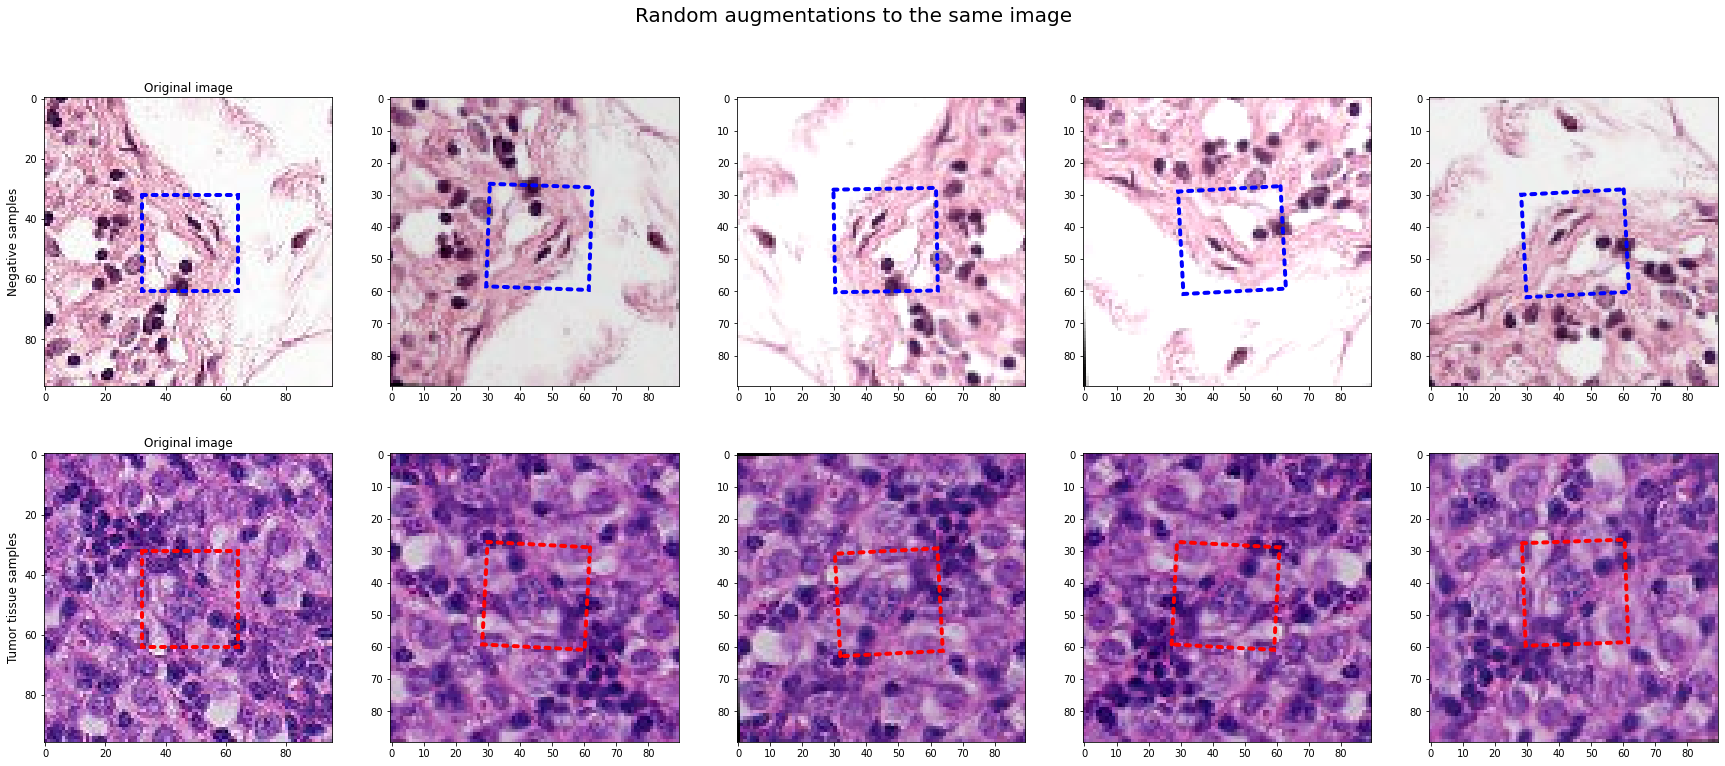

In [21]:
# See augmentation effect
fig, ax = plt.subplots(2,5, figsize=(30,12))
fig.suptitle('Random augmentations to the same image',fontsize=20)
# Negatives
# for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][1:2]):
    path = os.path.join(train_path, idx)
    ax[0,0].imshow(readImage(path + '.tif'))
    ax[0,0].set_title('Original image')
    # box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='g',
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',
                            facecolor='none', linestyle=':', capstyle='round')
    ax[0,0].add_patch(box)
    for j in range(1,5):
        img, rotation, x_shift, y_shift = readCroppedImage2(path + '.tif')
        ax[0,j].imshow(img)
       
        ts = ax[0,j].transData
        tr = mpl.transforms.Affine2D().rotate_deg_around(x = CROP_SIZE/2, y = CROP_SIZE/2, degrees = -rotation)
        tt = mpl.transforms.Affine2D().translate(x_shift, y_shift)
        t = tr + tt + ts
        
        box = patches.Rectangle((32-(ORIGINAL_SIZE - CROP_SIZE)/2,32-(ORIGINAL_SIZE - CROP_SIZE)/2),
                                # 32,32,linewidth=4,edgecolor='g',
                                32,32,linewidth=4,edgecolor='b',
                                facecolor='none', linestyle=':', capstyle='round',
                                transform = t)
        
        ax[0,j].add_patch(box)
        
ax[0,0].set_ylabel('Negative samples', size='large')
        
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:1]):
    path = os.path.join(train_path, idx)
    
    ax[1,0].imshow(readImage(path + '.tif'))
    ax[1,0].set_title('Original image')
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',
                            facecolor='none', linestyle=':', capstyle='round')
    ax[1,0].add_patch(box)
    
    for j in range(1,5):
        img, rotation, x_shift, y_shift = readCroppedImage2(path + '.tif')
        ax[1,j].imshow(img)
         
        ts = ax[1,j].transData
        tr = mpl.transforms.Affine2D().rotate_deg_around(x = CROP_SIZE/2, y = CROP_SIZE/2, degrees = -rotation)
        tt = mpl.transforms.Affine2D().translate(x_shift, y_shift)
        t = tr + tt + ts
        box = patches.Rectangle((32-(ORIGINAL_SIZE - CROP_SIZE)/2,32-(ORIGINAL_SIZE - CROP_SIZE)/2),
                                32,32,linewidth=4,edgecolor='r',
                                facecolor='none', linestyle=':', capstyle='round',
                                transform = t)
        ax[1,j].add_patch(box)
    #     ax[1,j].imshow(readCroppedImage(path + '.tif'))
    #     ax[1,j].set_title('Cropped image')
    #     box = patches.Rectangle((32-(ORIGINAL_SIZE - CROP_SIZE)/2,32-(ORIGINAL_SIZE - CROP_SIZE)/2),
    #                             32,32,linewidth=4,edgecolor='r',
    #                         facecolor='none', linestyle=':', capstyle='round')
    #     ax[1,j].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

### Compute image statistics

After calculating statistics, to check if there are images that have a very low maximum pixel intensity (almost totally black) or very high minimum pixel intensity (almost totally white). These kind of images could be caused by bad exposure or cropping to an empty area. In case of an empty area, the image would not be an outlier but equally valid negative sample. There are at least one very dark and 6 very bright images.

In [22]:
# As we count the statistics, we can check if there are any completely black or white images
dark_th = 10 / 255      # If no pixel reaches this threshold, image is considered too dark
bright_th = 245 / 255   # If no pixel is under this threshold, image is considerd too bright
too_dark_idx = []
too_bright_idx = []

x_tot = np.zeros(3)
x2_tot = np.zeros(3)
counted_ones = 0
for i, idx in tqdm_notebook(enumerate(data['id']), 'computing statistics...(220025 it total)'):
    path = os.path.join(train_path, idx)
    imagearray = readCroppedImage(path + '.tif', augmentations = False).reshape(-1,3)
    # is this too dark
    if(imagearray.max() < dark_th):
        too_dark_idx.append(idx)
        continue # do not include in statistics
    # is this too bright
    if(imagearray.min() > bright_th):
        too_bright_idx.append(idx)
        continue # do not include in statistics
    x_tot += imagearray.mean(axis=0)
    x2_tot += (imagearray**2).mean(axis=0)
    counted_ones += 1
    
channel_avr = x_tot/counted_ones
channel_std = np.sqrt(x2_tot/counted_ones - channel_avr**2)
channel_avr,channel_std

<ipython-input-22-38fc8b1ec049>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, idx in tqdm_notebook(enumerate(data['id']), 'computing statistics...(220025 it total)'):


computing statistics...(220025 it total): 0it [00:00, ?it/s]

(array([0.70244707, 0.54624322, 0.69645334]),
 array([0.23889325, 0.28209431, 0.21625058]))

In [ ]:
print('There was {0} extremely dark image'.format(len(too_dark_idx)))
print('and {0} extremely bright images'.format(len(too_bright_idx)))
print('Dark one:')
print(too_dark_idx)
print('Bright ones:')
print(too_bright_idx)

There was 1 extremely dark image
and 6 extremely bright images
Dark one:
['9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
Bright ones:
['9071b424ec2e84deeb59b54d2450a6d0172cf701', 'f6f1d771d14f7129a6c3ac2c220d90992c30c10b', '5f30d325d895d873d3e72a82ffc0101c45cba4a8', '54df3640d17119486e5c5f98019d2a92736feabc', '5a268c0241b8510465cb002c4452d63fec71028a', 'c448cd6574108cf14514ad5bc27c0b2c97fc1a83']


In [ ]:
data[data['id'].isin(too_dark_idx)]

,id,label
138245,9369c7278ec8bcc6c880d99194de09fc2bd4efbe,0


#### Plot very bright or very dark images

All the dark and bright images are labeled negative. The bright ones are just cropped from a non-stained part or they don't have any tissue (plain glass?) so the labels are correct. The samples don't have tumor tissue present. I am not so sure about the dark image, is it an outlier crop from badly exposed area or just some very large cell part filling the whole image. Anyway, removing only a small amount of outliers from this size data set has little or no effect on the prediction performance.

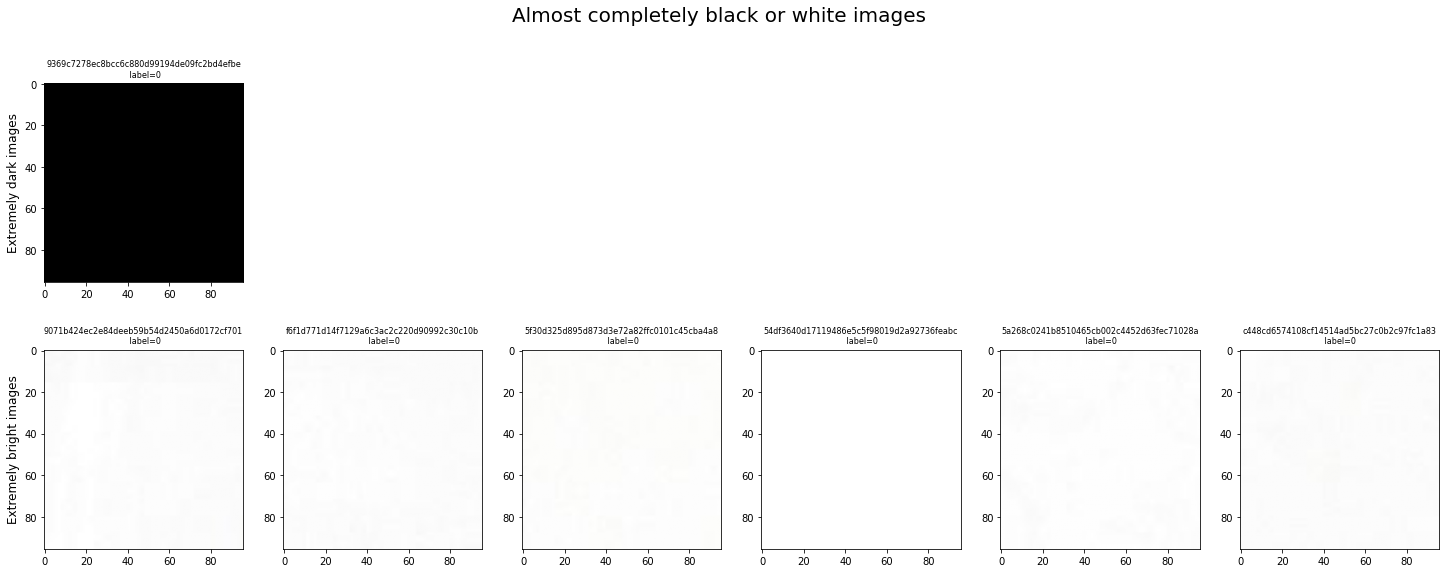

In [23]:
fig, ax = plt.subplots(2,6, figsize=(25,9))
fig.suptitle('Almost completely black or white images',fontsize=20)
# Too dark
i = 0
for idx in np.asarray(too_dark_idx)[:min(6, len(too_dark_idx))]:
    lbl = data[data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif', augmentations = False))
    ax[0,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8)
    i += 1
ax[0,0].set_ylabel('Extremely dark images', size='large')
for j in range(min(6, len(too_dark_idx)), 6):
    ax[0,j].axis('off') # hide axes if there are less than 6
# Too bright
i = 0
for idx in np.asarray(too_bright_idx)[:min(6, len(too_bright_idx))]:
    lbl = data[data['id'] == idx]['label'].values[0]
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif', augmentations = False))
    ax[1,i].set_title(idx + '\n label=' + str(lbl), fontsize = 8)
    i += 1
ax[1,0].set_ylabel('Extremely bright images', size='large')
for j in range(min(6, len(too_bright_idx)), 6):
    ax[1,j].axis('off') # hide axes if there are less than 6

## Preprocssing

To define the train and data split validation

In [66]:
df_train = pd.read_csv("/content/train_labels.csv")
id_label_map = {k:v for k,v in zip(df_train.id.values, df_train.label.values)}
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [67]:
def get_id_from_file_path(file_path):
    return file_path.split(os.path.sep)[-1].replace('.tif', '')

In [68]:
labeled_files = glob('/content/train/*.tif')
test_files = glob('/content/test/*.tif')

In [69]:
train, val = train_test_split(labeled_files, test_size=0.1, random_state=101010)

In [70]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
def get_seq():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq

def data_gen(list_files, id_label_map, batch_size, augment=False):
    seq = get_seq()
    while True:
        shuffle(list_files)
        for batch in chunker(list_files, batch_size):
            X = [cv2.imread(x) for x in batch]
            Y = [id_label_map[get_id_from_file_path(x)] for x in batch]
            if augment:
                X = seq.augment_images(X)
            X = [preprocess_input(x) for x in X]
                
            yield np.array(X), np.array(Y)
    

## Defining the model

We define the architecture of the model, which is a NASNetMobile neural network, pre-trained on imagenet database, which we have found to work well with this dataset. In addition, we add a few other layers to obtain the final predictions. the pre-loaded weights will help us to get a headstart on this particular problem.

In [71]:
def get_model_classif_nasnet():
    inputs = Input((96, 96, 3))
    base_model = NASNetMobile(include_top=False, input_shape=(96, 96, 3))#, weights=None
    x = base_model(inputs)
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.5)(out)
    out = Dense(1, activation="sigmoid", name="3_")(out)
    model = Model(inputs, out)
    model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
    model.summary()

    return model

In [72]:
model = get_model_classif_nasnet()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 NASNet (Functional)            (None, 3, 3, 1056)   4269716     ['input_7[0][0]']                
                                                                                                  
 global_max_pooling2d_3 (Global  (None, 1056)        0           ['NASNet[0][0]']                 
 MaxPooling2D)                                                                                    
                                                                                                  
 global_average_pooling2d_3 (Gl  (None, 1056)        0           ['NASNet[0][0]']           

## Training the model

In [74]:
batch_size=32
h5_path = "model.h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=2, verbose=1,
    callbacks=[checkpoint],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)
batch_size=64
history = model.fit_generator(
    data_gen(train, id_label_map, batch_size, augment=True),
    validation_data=data_gen(val, id_label_map, batch_size),
    epochs=6, verbose=1,
    callbacks=[checkpoint],
    steps_per_epoch=len(train) // batch_size,
    validation_steps=len(val) // batch_size)


<ipython-input-74-e98c7edcfc8c>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-74-e98c7edcfc8c>", line 5, in <module>
    history = model.fit_generator(
  File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2604, in fit_generator
    return self.fit(
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1650, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 880, in __call__
    result = self._call

KeyboardInterrupt: ignored

## Assessing performance

In [ ]:
model.load_weights(h5_path)

In [ ]:
val_preds = []
val_ids = []

In [ ]:
for batch in chunker(val, batch_size):
    X = [preprocess_input(cv2.imread(x)) for x in batch]
    ids_batch = [get_id_from_file_path(x) for x in batch]
    X = np.array(X)
    preds_batch = ((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    val_preds += preds_batch
    val_ids += ids_batch

In [ ]:
val_preds_cat = (np.array(val_preds) > 0.5).astype(int)

In [ ]:
y_val = np.array([id_label_map[get_id_from_file_path(x)] for x in val])
print("Accuracy is: ", accuracy_score(y_val, val_preds_cat))
print("AUC_ROC score is: ", roc_auc_score(y_val, val_preds))

AUC_ROC score is:  0.952646416031849


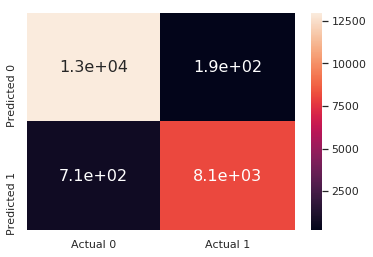

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(y_val, val_preds_cat), index=["Predicted 0", "Predicted 1"], columns=["Actual 0", "Actual 1"])
sns.set(font_scale=1.0) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})